# 1ra parte - Modelos supervisados

En esta primera parte se aplicó los modelos naive bayes, arboles de decisión, random forest y redes neuronales con el fin de determinar cual de estos modelos supervisados tiene mejores estimaciones para establecer si una persona es obesa teniendo en cuenta sus hábitos alimenticios y su condición física. 

En esta ocasión se empleó la base de datos de “Estimation of Obesity Levels Based On Eating Habits and Physical Condition” de la UC Irvine Machine Learning Repository, la cual incluye información sobre la estimación de los niveles de obesidad en personas en los países de México, Perú y Colombia con base a sus hábitos y condición física. Esta base está compuesta por 2111 registros y por 17 variables las cuales se describen mediante la siguiente tabla:


In [3]:
from ucimlrepo import fetch_ucirepo
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables

,name,role,type,demographic,description,units,missing_values
0,Gender,Feature,Categorical,Gender,None,None,no
1,Age,Feature,Continuous,Age,None,None,no
2,Height,Feature,Continuous,None,None,None,no
3,Weight,Feature,Continuous,None,None,None,no
4,family_history_with_overweight,Feature,Binary,None,Has a family member suffered or suffers from o...,None,no
5,FAVC,Feature,Binary,None,Do you eat high caloric food frequently?,None,no
6,FCVC,Feature,Integer,None,Do you usually eat vegetables in your meals?,None,no
7,NCP,Feature,Continuous,None,How many main meals do you have daily?,None,no
8,CAEC,Feature,Categorical,None,Do you eat any food between meals?,None,no
9,SMOKE,Feature,Binary,None,Do you smoke?,None,no


Cabe resaltar que, para fines del ejercicio se excluyeron las variables Height y Weight debido a que tienen una alta correlación con la obesidad como se muestra en el índice de masa corporal (IMC) el cual es una medida de la obesidad que se determina por estas dos variables.

# Preparación de los datos

Se empieza a realizar la importación de las librerias necesarias para el ejercicio

In [4]:
# importar librerias para el proyecto
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, tree
from sklearn.feature_selection import RFE
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import dtreeviz
from sklearn.model_selection import GridSearchCV
import joblib as joblib
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, f1_score, accuracy_score, recall_score
from tabulate import tabulate
#from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_curve, auc


In [5]:
# Cargamos los datos  
datos = pd.read_csv("../Datos/ObesityDataSet_raw_and_data_sinthetic.csv")
datos.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


In [6]:
datos.describe()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


A continuación, se realizó la separición de las variables categoricas y númericas en conjunto de la separación de la base en testeo y train. Adicionalmente para la variable objetivo "NObeyesdad" se agruparon sus 6 categorias en dos, siendo el estado 1 si el individuo es obeso y 0 que no lo es.

In [7]:
rng = np.random.RandomState(seed=30) # Algo pasa con la semilla pero en X_train la variable CAEC queda sin always, por eso al ajustar el modelo no encuentra la categoría
categorical= ["Gender","family_history_with_overweight", "FAVC","SMOKE", "SCC","CAEC","CALC",'MTRANS']
numerical_columns = ["Age", "FCVC", "NCP", "CH2O", "FAF","TUE"]
X = datos[numerical_columns +categorical]
y = datos["NObeyesdad"]
y = pd.DataFrame(datos['NObeyesdad'].map({'Normal_Weight': 0, 'Insufficient_Weight': 0, 'Overweight_Level_I':0,'Overweight_Level_II':0, 'Obesity_Type_I':1,'Obesity_Type_II':1, 'Obesity_Type_III':1}))
yname = ["NObeyesdad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=54)

## Preprocessing


Se aplicó la función de ColumnTransformer para llevar a cabo la transformación de los datos. En el caso de las variables categóricas, se empleó la función OneHotEncoder para su conversión a formato numérico. En cuanto a las variables numéricas, se llevó a cabo la escalación utilizando la función StandardScaler.

In [8]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore') 
numerical_pipe = StandardScaler()

preprocessing = ColumnTransformer(
    [
        ("codificacion de categoricas",categorical_encoder, categorical),
        ("Transformación de numéricas", numerical_pipe, numerical_columns)
    ],
    verbose_feature_names_out=False,
)


A continuación, se realiza la estimación de los modelos supervisados y se eligira cual es el mejor para deterinar si los individuos son obesos.

# Logistic Model

Se implementó el modelo logístico mediante las funciones Pipeline y GridSearchCV con el objetivo de generar múltiples modelos logísticos y seleccionar el que obtenga el mejor rendimiento en términos de precisión (accuracy).

In [9]:
logit = LogisticRegression(random_state=30)
modelo_logit = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", logit),  
    ]
)

In [10]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {'Classifier__penalty': ['l1', 'l2'],           # Tipo de penalización
              'Classifier__C': [0.001, 0.01, 0.1, 1, 10],    # Parámetro de regularización inversa (más pequeño es más fuerte)
              'Classifier__max_iter': [100, 200, 300],        # Número máximo de iteraciones
              'Classifier__fit_intercept': [True, False],     # Ajustar o no la intercepción
              'Classifier__class_weight': [None, 'balanced'] } # Manejo de clases desbalanceadas}

best_log = GridSearchCV(modelo_logit, param_grid, cv=5, scoring='accuracy')
best_log.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-v

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier',
                                        LogisticRegression(random_state=30))]),
             param_grid={'Classifier__C': [0.001, 0.01, 0.1, 1, 10],
                         'Classifier__class_weight': [None, 'balanced'],
                         'Classifier__fit_intercept': [True, False],
                         'Classifier__max_iter': [100, 200, 300],
                         'Classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

Dentro de los diferentes modelos lógicticos creados, se eligio el mejor modelo con un accurency de 0.7518 con datos de testeo y de 0.7833 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8257, bajo las siguientes especificaciones:

- 'Classifier__C': 10: Un valor más alto de C indica una regularización más débil, lo que significa que el modelo puede ajustarse más a los datos de entrenamiento. En este caso es una regularización relativamente débil.

- 'Classifier__class_weight': 'balanced': Las clases menos representadas tendrán un peso mayor para equilibrar el impacto de las clases más frecuentes durante el entrenamiento del modelo.

- 'Classifier__fit_intercept': True: Se permite que el modelo tenga un término de intercepción.

- 'Classifier__max_iter': 200: Representa el número máximo de iteraciones permitidas durante la optimización del modelo.

- 'Classifier__penalty': 'l2': Este parámetro especifica el tipo de regularización que se aplica al modelo. En este caso, 'l2' se refiere a la regularización de norma L2, que penaliza los coeficientes cuadrados grandes en la función de pérdida.


In [11]:
best_log.best_params_

{'Classifier__C': 10,
 'Classifier__class_weight': 'balanced',
 'Classifier__fit_intercept': True,
 'Classifier__max_iter': 200,
 'Classifier__penalty': 'l2'}

En total, se estima que del total de individuos mal clasificados (131), 37 son falsos negativos y 94 son falsos positivos, lo que resulta en una sensibilidad del 0.8477 y una precisión del 0.6867.

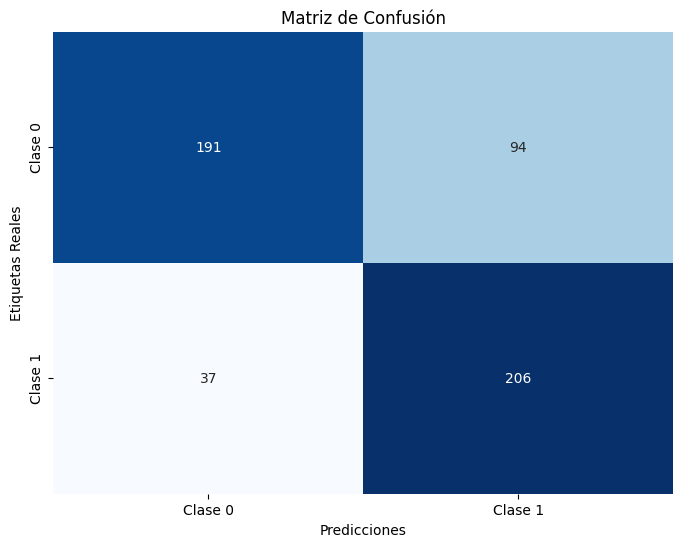

In [12]:
from sklearn.metrics import confusion_matrix

y_test1= pd.DataFrame(y_test)
y_predlog = best_log.predict(X_test)
cm = confusion_matrix(y_test1, y_predlog)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [13]:
print("Rendimiento con datos de entrenamiento",round(best_log.best_score_,4))
print("Rendimiento con datos nuevos", round(best_log.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predlog),4))
print("Precisión", round(precision_score(y_test, y_predlog),4))

Rendimiento con datos de entrenamiento 0.7833
Rendimiento con datos nuevos 0.7519
Sensibilidad 0.8477
Precisión 0.6867


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predlog))

              precision    recall  f1-score   support

           0       0.84      0.67      0.74       285
           1       0.69      0.85      0.76       243

    accuracy                           0.75       528
   macro avg       0.76      0.76      0.75       528
weighted avg       0.77      0.75      0.75       528



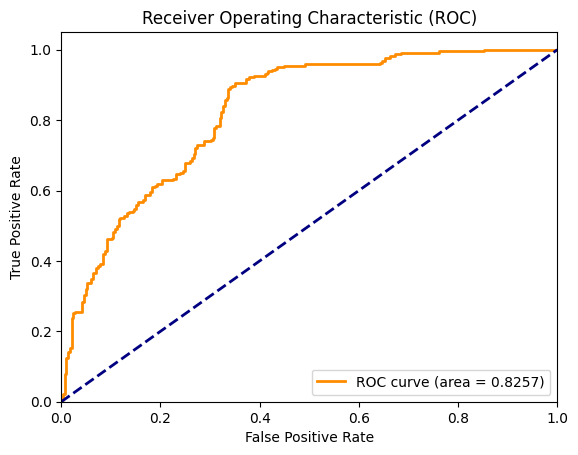

In [15]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_log.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auclog = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auclog)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Arbol de decisión

Se aplicó el modelo con Arbol de decisión utilizando las funciones Pipeline y GridSearchCV, con la finalidad de crear diversos modelos y elegir aquel que logre el mejor desempeño en cuanto a precisión (accuracy).

In [16]:
arbol = DecisionTreeClassifier(random_state=30)
modelo_arbol = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", arbol),  
    ]
)

In [17]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {"Classifier__criterion": ['entropy', 'gini','log_loss'],
              "Classifier__max_depth": range(2, 6),
              "Classifier__min_samples_leaf": range(2, 10)}

best_tree = GridSearchCV(modelo_arbol, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
best_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier',
                                        DecisionTreeClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'Classifier__criterion': ['entropy', 'gini',
                                                   'log_loss'],
                         'Classifier__max_depth': range(2, 6),
                         'Classifier__min_samples_leaf': range(2, 10)},
             scoring='accuracy')

Dentro de los diferentes modelos de árbol de decisión creados, se eligio el mejor modelo con un accurency de 0.7896 con datos de testeo y de 0.7833 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8257, bajo las siguientes especificaciones:

- clasificador__criterion: En este caso, se utiliza el índice de Gini. El índice de Gini mide la impureza de un conjunto de datos, y el algoritmo de árbol de decisión buscará las divisiones que minimicen esta impureza.

- clasificador__max_depth: Este parámetro controla la profundidad máxima del árbol de decisión. Se ha establecido en 5, lo que significa que el árbol se construirá con un máximo de 5 niveles de profundidad desde el nodo raíz hasta las hojas.

- clasificador__min_samples_leaf: Este parámetro establece el número mínimo de muestras requeridas en una hoja del árbol. Lo que significa que una hoja del árbol debe contener al menos 5 muestras.

In [18]:
best_tree.best_params_

{'Classifier__criterion': 'gini',
 'Classifier__max_depth': 5,
 'Classifier__min_samples_leaf': 5}

En total, se estima que del total de individuos mal clasificados (138), 81 son falsos negativos y 57 son falsos positivos, lo que resulta en una sensibilidad del 0.8477 y una precisión del 0.6867

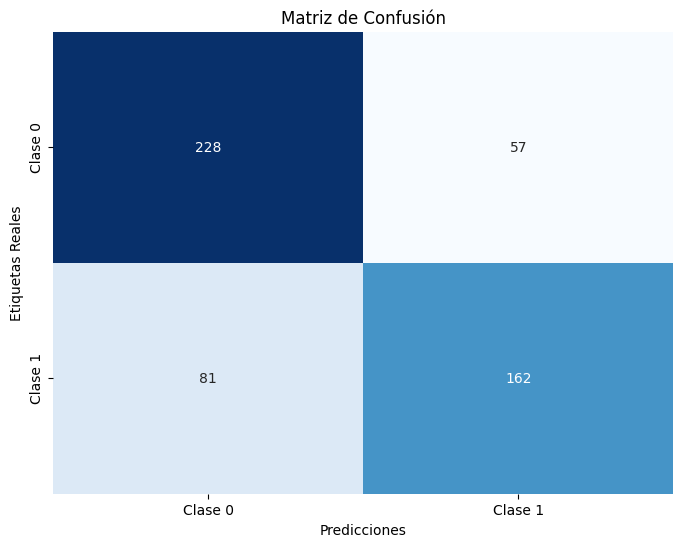

In [19]:
from sklearn.metrics import confusion_matrix

y_test1= pd.DataFrame(y_test)
y_predtree = best_tree.predict(X_test)
cm = confusion_matrix(y_test1, y_predtree)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [20]:
print("Accuracy con datos de entrenamiento",round(best_tree.best_score_,4))
print("Accuracy con datos nuevos", round(best_tree.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predtree),4))
print("Precisión", round(precision_score(y_test, y_predtree),4))

Accuracy con datos de entrenamiento 0.7896
Accuracy con datos nuevos 0.7386
Sensibilidad 0.6667
Precisión 0.7397


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predtree))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       285
           1       0.74      0.67      0.70       243

    accuracy                           0.74       528
   macro avg       0.74      0.73      0.73       528
weighted avg       0.74      0.74      0.74       528



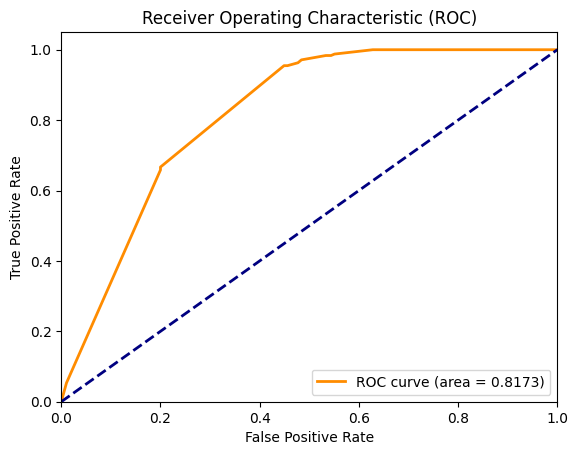

In [22]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_tree.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auctree = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auctree)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Random Forest


Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Random Forest. El propósito fue generar diversos modelos logísticos y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [23]:
# Random Forest
modelo=RandomForestClassifier(random_state=30)
modelo_rf = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("clasificador", modelo),
    ]
)


In [24]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {'clasificador__criterion': ['entropy', 'log_loss', 'gini'],
              'clasificador__max_depth': range(3, 10),
              'clasificador__min_samples_leaf': range(2, 10)}
best_rf = GridSearchCV(modelo_rf, param_grid, scoring='accuracy', n_jobs=-1)
best_rf.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('clasificador',
                                        RandomForestClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'clasificador__criterion': ['entropy', 'log_loss',
                                                     'gini'],
                         'clasificador__max_depth': range(3, 10),
                         'clasificador__min_samples_leaf': range(2, 10)},
             scoring='accuracy')

Dentro de los diferentes modelos Random Forest creados, se eligio el mejor modelo con un accurency de 0.8977 con datos de testeo y de 0.8926 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.9579, bajo las siguientes especificaciones:

- clasificador__criterion: Este parámetro indica el criterio utilizado para medir la calidad de una división en el árbol de decisión. En este caso, se ha configurado con 'entropy'. La ganancia de información mide la reducción de la incertidumbre y se utiliza para seleccionar la mejor característica para dividir los nodos del árbol.

- clasificador__max_depth: Este parámetro controla la profundidad máxima del árbol de decisión. En tu configuración, se ha establecido en 9, lo que significa que el árbol se construirá con un máximo de 9 niveles de profundidad desde el nodo raíz hasta las hojas.

- clasificador__min_samples_leaf: Este parámetro establece el número mínimo de muestras requeridas en una hoja del árbol. Lo que significa que una hoja del árbol debe contener al menos 2 muestras.

In [25]:
best_rf.best_params_

{'clasificador__criterion': 'entropy',
 'clasificador__max_depth': 9,
 'clasificador__min_samples_leaf': 2}

En total, se estima que del total de individuos mal clasificados (54), 19 son falsos negativos y 35 son falsos positivos, lo que resulta en una sensibilidad del 0.9218 y una precisión del 0.8649.

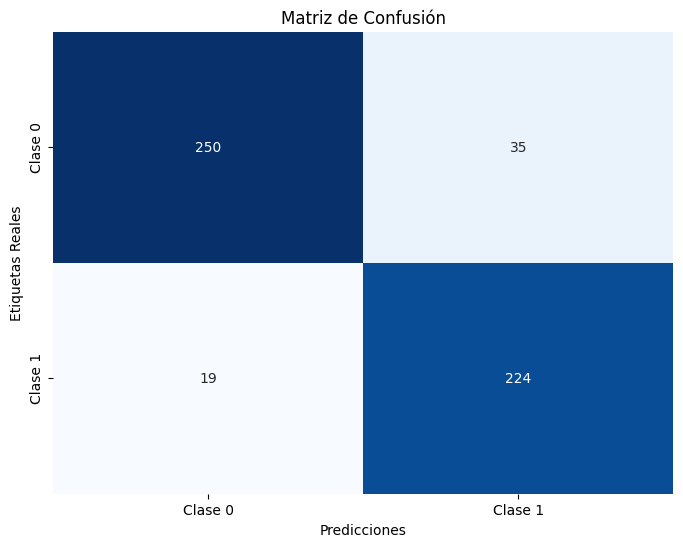

In [26]:
y_test1= pd.DataFrame(y_test)
y_predrf = best_rf.predict(X_test)
cm = confusion_matrix(y_test1, y_predrf)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [27]:
print("Accuracy con datos de entrenamiento",round(best_rf.best_score_,4))
print("Accuracy con datos nuevos", round(best_rf.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predrf),4))
print("Precisión", round(precision_score(y_test, y_predrf),4))

Accuracy con datos de entrenamiento 0.8926
Accuracy con datos nuevos 0.8977
Sensibilidad 0.9218
Precisión 0.8649


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predrf))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       285
           1       0.86      0.92      0.89       243

    accuracy                           0.90       528
   macro avg       0.90      0.90      0.90       528
weighted avg       0.90      0.90      0.90       528



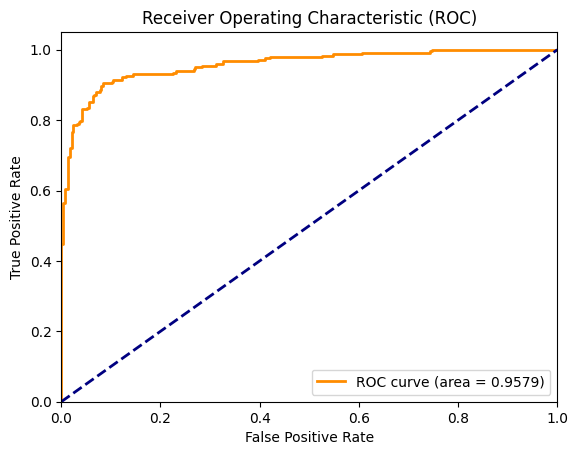

In [29]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_rf.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucrf = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucrf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Naive Bayes

Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Naive Bayes. El propósito fue generar diversos modelos logísticos y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [30]:
gnb=GaussianNB()
modelo_GNB = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", gnb),  
    ]
)

k_fold = StratifiedKFold(5, shuffle=True, random_state=54)
param_grid = {}
#param_grid ={}
best_GNB = GridSearchCV(modelo_GNB, param_grid, scoring='accuracy', n_jobs=-1)
best_GNB.fit(X_train, y_train)


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier', GaussianNB())]),
             n_jobs=-1, param_grid={}, scoring='accuracy')

A diferencia de otros modelos, El naive bayes no requiere de hiperparametros para su realización. Sin embargo, mediante la grilla se corrieron varios modelos y al final se escogío el modelo con un accurency de 0.7481 con datos de testeo y de 0.7663 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8368.

En total, se estima que del total de individuos mal clasificados (133), 17 son falsos negativos y 116 son falsos positivos, lo que resulta en una sensibilidad del 0.9300 y una precisión del 0.6608.

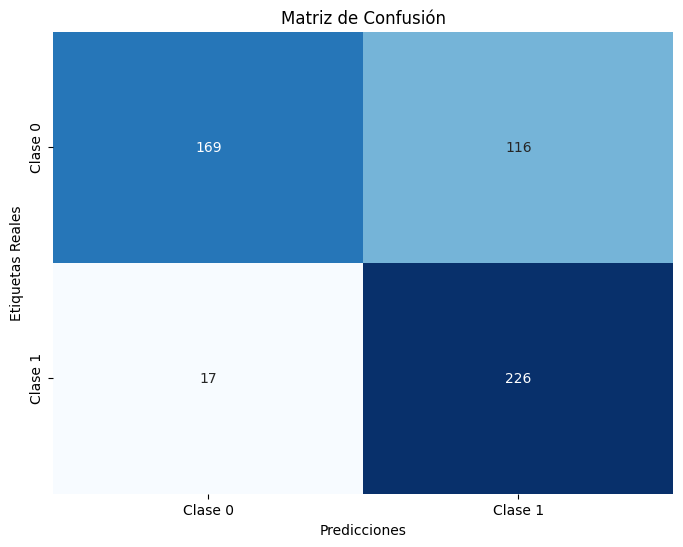

In [31]:
y_test1= pd.DataFrame(y_test)
y_predGNB = best_GNB.predict(X_test)
cm = confusion_matrix(y_test1, y_predGNB)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [32]:
print("Accuracy con datos de entrenamiento",round(best_GNB.best_score_,4))
print("Accuracy con datos nuevos", round(best_GNB.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predGNB),4))
print("Precisión", round(precision_score(y_test, y_predGNB),4))

Accuracy con datos de entrenamiento 0.7663
Accuracy con datos nuevos 0.7481
Sensibilidad 0.93
Precisión 0.6608


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predGNB))

              precision    recall  f1-score   support

           0       0.91      0.59      0.72       285
           1       0.66      0.93      0.77       243

    accuracy                           0.75       528
   macro avg       0.78      0.76      0.75       528
weighted avg       0.79      0.75      0.74       528



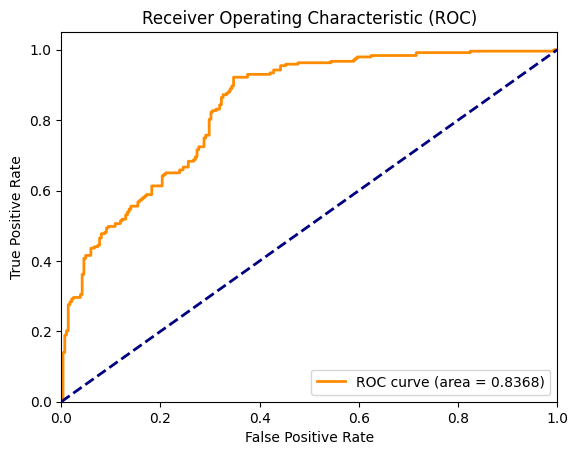

In [34]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_GNB.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucGNB = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucGNB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Redes Neuronales

Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Redes Neuronales. El propósito fue generar diversos modelos de Redes Neuronales y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [35]:
red = Sequential()
red.add(Dense(1, input_shape=(28,) ,activation='softmax'))
red.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


modelo_red = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", red),
    ]
)

modelo_red.fit(X_train, y_train)


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4635 - loss: 0.0000e+00 


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('codificacion de categoricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'CAEC', 'CALC', 'MTRANS']),
                                                 ('Transformación de numéricas',
                                                  StandardScaler(),
                                                  ['Age', 'FCVC', 'NCP', 'CH2O',
                                                   'FAF', 'TUE'])],
                                   verbose_feature_names_out=False)),
                ('Classifier', <Sequential name=sequential, built=True>)])

In [36]:
red_neuronal = MLPClassifier()
rn_mlp = Pipeline(
    [
    ("preprocessing",preprocessing),
    ("Classifier",red_neuronal)    
    ]
)

In [37]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid ={ "Classifier__hidden_layer_sizes":[(10,), (20,), (30,)],
             "Classifier__activation":['identity','logistic','tanh','relu'],
             "Classifier__solver":['lbfgs','sgd','adam'],
             "Classifier__alpha":[0.0001, 0.001, 0.01, 0.1],
             "Classifier__learning_rate":['constant','invscaling','adaptative']}


best_neuralnetwork = GridSearchCV(rn_mlp, param_grid, scoring='accuracy', n_jobs=-1)
best_neuralnetwork.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LauraCuestas\anaconda3\envs\t

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_f...e)),
                                       ('Classifier', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'Classifier__activation': ['identity', 'logistic',
                                                    'tanh', 'relu'],
                         'Classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'Classifier__hidden_layer_sizes': [(10,), (20,),
                                                            (30,)],
                         'Classifier__learning_rate': ['constant', 'invscaling',
                                                       'adaptative'],
                         'Classifier__solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy')

Apartir de la realización de diferentes modelos de redes neuronales, se eligio el mejor modelo con un accurency de 0.8977 con datos de testeo y de 0.9160 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.9468, bajo las siguientes especificaciones:

- Classifier__activation: 'logistic'
En este caso, se ha seleccionado la función logística (también conocida como función sigmoide). La función logística transforma la entrada en un rango entre 0 y 1.

- Classifier__alpha: 0.1
La regularización ayuda a prevenir el sobreajuste al penalizar pesos grandes. Un valor de alpha más alto implica una regularización más fuerte y el implementado en este modelo es relativamente alto.

- Classifier__hidden_layer_sizes: (30,)
Indica la arquitectura de la red neuronal, es decir, el número de neuronas en cada capa oculta. En este caso, hay una única capa oculta con 30 neuronas.

- Classifier__learning_rate: 'invscaling'
En este caso, se utiliza la tasa de aprendizaje 'invscaling', que reduce la tasa de aprendizaje a medida que avanza el entrenamiento.

- Classifier__solver: 'lbfgs'
Se ha seleccionado 'lbfgs', que es un algoritmo de optimización de segundo orden bien adaptado para problemas de optimización convexa.

In [38]:
best_neuralnetwork.best_params_

{'Classifier__activation': 'logistic',
 'Classifier__alpha': 0.1,
 'Classifier__hidden_layer_sizes': (30,),
 'Classifier__learning_rate': 'constant',
 'Classifier__solver': 'lbfgs'}


En total, se estima que del total de individuos mal clasificados (59), 20 son falsos negativos y 39 son falsos positivos, lo que resulta en una sensibilidad del 0.9177 y una precisión del 0.8511.

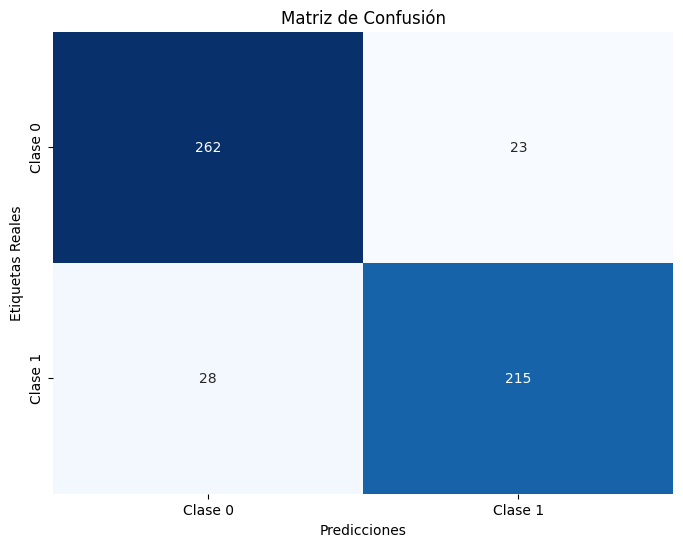

In [39]:
y_test1= pd.DataFrame(y_test)
y_predRED = best_neuralnetwork.predict(X_test)
cm = confusion_matrix(y_test1, y_predRED)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [40]:
print("Accuracy con datos de entrenamiento",round(best_neuralnetwork.best_score_,4))
print("Accuracy con datos nuevos", round(best_neuralnetwork.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predRED),4))
print("Precisión", round(precision_score(y_test, y_predRED),4))

Accuracy con datos de entrenamiento 0.909
Accuracy con datos nuevos 0.9034
Sensibilidad 0.8848
Precisión 0.9034


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predRED))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       285
           1       0.90      0.88      0.89       243

    accuracy                           0.90       528
   macro avg       0.90      0.90      0.90       528
weighted avg       0.90      0.90      0.90       528



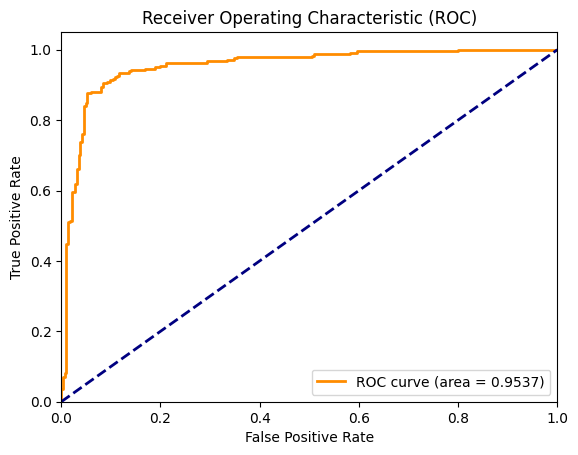

In [42]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_neuralnetwork.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucRED = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucRED)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Al contrastar todos los modelos previamente mencionados, destaca que la Red Neuronal exhibe una precisión superior en la predicción de personas con obesidad (Precisión: 0.9237), y además, una exactitud global mayor que la de los demás modelos (Accuracy: 0.9186). Es relevante señalar que, a excepción del modelo Random Forest, la Red Neuronal también presenta uno de los AUC más altos en comparación con los otros modelos. Esto sugiere una capacidad de clasificación y discriminación más robusta en cuanto a los diferentes estados de la variable obesidad.

In [43]:
data = {'Modelo':['Logistico', 'Arbol de decisión', 'Random Forest', 'Naive Bayes', 'Red Neuronal'],
        'Precisión':[round(precision_score(y_test, y_predlog),ndigits=4), round(precision_score(y_test, y_predtree),ndigits=4), round(precision_score(y_test, y_predrf),ndigits=4), round(precision_score(y_test, y_predGNB),ndigits=4), round(precision_score(y_test, y_predRED),ndigits=4)],
        'Sensibilidad':[round(recall_score(y_test, y_predlog),ndigits=4), round(recall_score(y_test, y_predtree),ndigits=4), round(recall_score(y_test, y_predrf),ndigits=4), round(recall_score(y_test, y_predGNB),ndigits=4), round(recall_score(y_test, y_predRED),ndigits=4)],
        'F1':[round(f1_score(y_test, y_predlog),ndigits=4), round(f1_score(y_test, y_predtree),ndigits=4), round(f1_score(y_test, y_predrf),ndigits=4), round(f1_score(y_test, y_predGNB),ndigits=4), round(f1_score(y_test, y_predRED),ndigits=4)],
        'AUC':[round(roc_auclog,ndigits=4), round(roc_auctree,ndigits=4), round(roc_aucrf,ndigits=4), round(roc_aucGNB,ndigits=4), round(roc_aucRED,ndigits=4)],
        'Accuracy':[round(best_log.score(X_test,y_test),4), round(best_tree.score(X_test,y_test),4), round(best_rf.score(X_test,y_test),4), round(best_GNB.score(X_test,y_test),4), round(best_neuralnetwork.score(X_test,y_test),4)]}
Modelo=['Logistico', 'Arbol de decisión', 'Random Forest', 'Naive Bayes', 'Red Neuronal']
data = pd.DataFrame(data, index=None)


print(tabulate(data.sort_values(by='Accuracy', ascending=False), headers='keys', tablefmt='pretty', showindex=False))

+-------------------+-----------+--------------+--------+--------+----------+
|      Modelo       | Precisión | Sensibilidad |   F1   |  AUC   | Accuracy |
+-------------------+-----------+--------------+--------+--------+----------+
|   Red Neuronal    |  0.9034   |    0.8848    | 0.894  | 0.9537 |  0.9034  |
|   Random Forest   |  0.8649   |    0.9218    | 0.8924 | 0.9579 |  0.8977  |
|     Logistico     |  0.6867   |    0.8477    | 0.7587 | 0.8257 |  0.7519  |
|    Naive Bayes    |  0.6608   |     0.93     | 0.7726 | 0.8368 |  0.7481  |
| Arbol de decisión |  0.7397   |    0.6667    | 0.7013 | 0.8173 |  0.7386  |
+-------------------+-----------+--------------+--------+--------+----------+


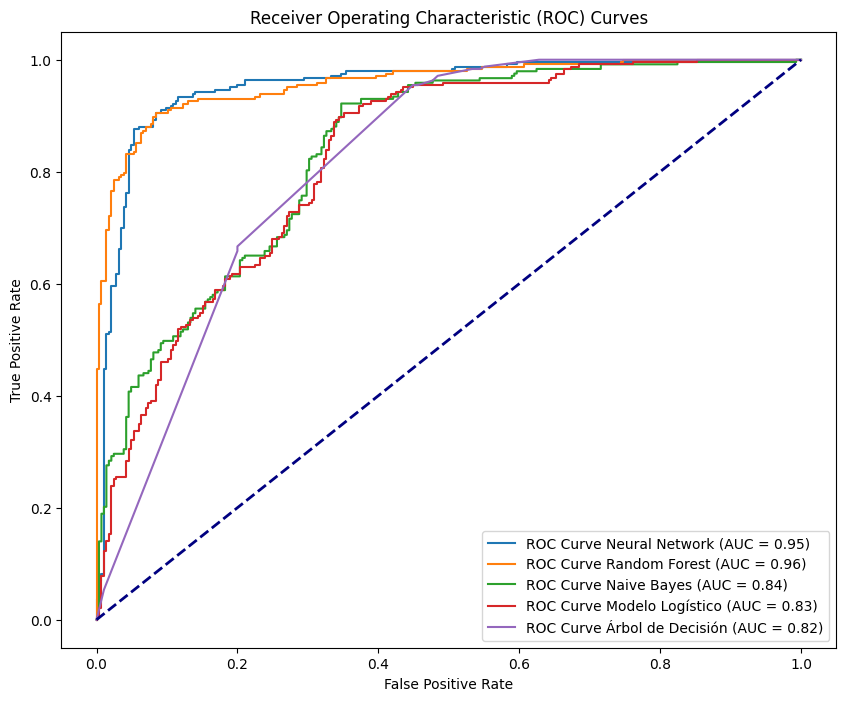

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scoresRed = best_neuralnetwork.predict_proba(X_test)[:, 1]
y_scoresRF = best_rf.predict_proba(X_test)[:, 1]
y_scoresGNB = best_GNB.predict_proba(X_test)[:, 1]
y_scoresLog = best_log.predict_proba(X_test)[:, 1]
y_scoresTree = best_tree.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Supongamos que tienes tres conjuntos de datos de prueba y predicciones
# Guarda las tasas de verdaderos positivos (TPR) y tasas de falsos positivos (FPR) para cada conjunto
fpr1, tpr1, _ = roc_curve(y_test, y_scoresRed)
fpr2, tpr2, _ = roc_curve(y_test, y_scoresRF)
fpr3, tpr3, _ = roc_curve(y_test, y_scoresGNB)
fpr4, tpr4, _ = roc_curve(y_test, y_scoresLog)
fpr5, tpr5, _ = roc_curve(y_test, y_scoresTree)

# Calcula el área bajo la curva (AUC) para cada conjunto de datos
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)

# Crea una figura y subgráficos
fig, ax = plt.subplots(figsize=(10, 8))

# Traza las curvas ROC para cada conjunto de datos en subgráficos diferentes
ax.plot(fpr1, tpr1, label=f'ROC Curve Neural Network (AUC = {roc_auc1:.2f})')
ax.plot(fpr2, tpr2, label=f'ROC Curve Random Forest (AUC = {roc_auc2:.2f})')
ax.plot(fpr3, tpr3, label=f'ROC Curve Naive Bayes (AUC = {roc_auc3:.2f})')
ax.plot(fpr4, tpr4, label=f'ROC Curve Modelo Logístico (AUC = {roc_auc4:.2f})')
ax.plot(fpr5, tpr5, label=f'ROC Curve Árbol de Decisión (AUC = {roc_auc5:.2f})')

# Agrega la línea diagonal para la clasificación aleatoria en todos los subgráficos
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etiqueta los ejes y agrega una leyenda
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves')
ax.legend(loc='lower right')

# Muestra la gráfica
plt.show()

# Interpretación del Mejor modelo: Red Neuronal

In [45]:
def custom_transformer(X):
    # Definir las columnas categóricas y numéricas según tu conjunto de datos
    categorical= ["Gender","family_history_with_overweight", "FAVC","SMOKE", "SCC","CAEC","CALC",'MTRANS']
    numerical_columns = ["Age", "FCVC", "NCP", "CH2O", "FAF","TUE"]

    # Crear un ColumnTransformer con las transformaciones deseadas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),  # Estandarizar variables numéricas
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)  # Codificar variables categóricas
        ],
    )

    # Devolver el conjunto de datos transformado
    return preprocessor.fit_transform(X)

In [46]:
X_train2 = custom_transformer(X_train)
X_train2 = pd.DataFrame(X_train2)
X_train2

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.244404,1.063262,-0.195748,-0.571801,-0.007340,-1.085025,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.146790,0.659820,-0.710887,1.606762,1.330131,-0.749817,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.881388,0.417079,-2.040461,-1.059858,-0.826965,-0.449275,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.150998,-0.808606,0.405288,-1.621915,-1.211424,0.558330,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.992107,-2.622167,0.405288,-0.053869,-1.178309,0.558330,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,1.026210,0.926966,0.405288,-0.793986,-0.151371,0.583748,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1579,-0.523208,1.063262,0.405288,-0.325083,0.766637,0.373269,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1580,1.151438,0.646145,0.405288,0.179204,-0.124171,-0.605823,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1581,-0.946314,-2.417261,1.005109,-1.621915,1.137006,0.558330,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
red_neuronal = MLPClassifier(activation='logistic',
        alpha=0.1,
        hidden_layer_sizes=(30,),
        learning_rate='invscaling',
        solver='lbfgs', verbose=True,
        random_state=30)

red_neuronal.fit(X_train2, y_train)
print(best_neuralnetwork.best_score_, best_neuralnetwork.score(X_test,y_test))

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9090484366888951 0.9034090909090909


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [48]:
from sklearn.metrics import accuracy_score, log_loss
# Inicializar listas para almacenar precisión y pérdidas por época
accuracies = []
losses = []

# Bucle de entrenamiento por épocas
for epoch in range(1, 50):
    # Entrenar el modelo utilizando fit en lugar de partial_fit
    red_neuronal = MLPClassifier(activation='logistic',
        alpha=0.1,
        hidden_layer_sizes=(30,),
        learning_rate='invscaling',
        solver='lbfgs', verbose=True,
        random_state=30, max_iter=epoch)
    red_neuronal.fit(X_train2, y_train)

    # Calcular la precisión en el conjunto de entrenamiento
    y_pred = red_neuronal.predict(X_train2)
    accuracy = accuracy_score(y_train, y_pred)
    accuracies.append(accuracy)

    # Calcular la pérdida logarítmica (log loss) en el conjunto de entrenamiento
    y_prob = red_neuronal.predict_proba(X_train2)
    loss = log_loss(y_train, y_prob)
    losses.append(loss)



c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

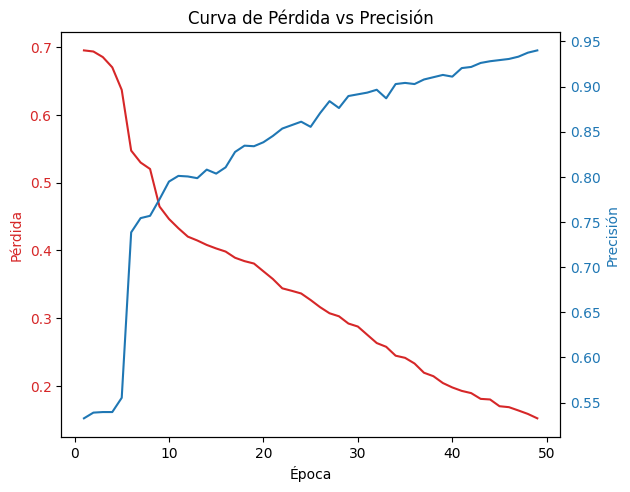

In [49]:

# Plotear la curva de pérdida versus precisión
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida', color=color)
ax1.plot(range(1, red_neuronal.max_iter + 1), losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precisión', color=color)
ax2.plot(range(1, red_neuronal.max_iter + 1), accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Curva de Pérdida vs Precisión')
plt.show()

In [50]:
primer_paso=rn_mlp['preprocessing']
primer_paso.get_feature_names_out()
primer_paso.transform(X_train)
import pandas as pd
DF=pd.DataFrame(primer_paso.transform(X_train), columns=primer_paso.get_feature_names_out())
DF.head(10)

,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Age,FCVC,NCP,CH2O,FAF,TUE
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.244404,1.063262,-0.195748,-0.571801,-0.007340,-1.085025
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.146790,0.659820,-0.710887,1.606762,1.330131,-0.749817
2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.881388,0.417079,-2.040461,-1.059858,-0.826965,-0.449275
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-1.150998,-0.808606,0.405288,-1.621915,-1.211424,0.558330
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.992107,-2.622167,0.405288,-0.053869,-1.178309,0.558330
5,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,-1.150998,-0.808606,0.405288,1.632549,1.137006,0.558330
6,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.869603,1.063262,0.405288,1.419762,0.509894,-0.053185
7,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.992107,1.063262,0.405288,0.005317,0.281786,-0.829848
8,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.279017,1.063262,0.405288,1.258489,-1.211424,-0.940022
9,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.582653,-0.750117,0.405288,1.311987,1.118782,-0.397079


Capa 0:
[-3.14257865  2.85482537  1.63315544 -0.69874173 -1.20745768 -0.67646356
 -0.25755482  1.17968656  1.0315553  -0.54974951  1.1924825  -0.47820257
  2.19426871 -0.18861106  1.79305556 -3.68707949 -1.01443187 -2.58757709
  2.64521591  1.23250988  2.51410646 -1.50017896  0.95884684 -2.31784592
  2.84591989  1.90600949 -2.81346997  0.0425685  -4.20242124  1.49246612]
Capa 1:
[-0.60737374  0.28035774 -0.48209331 -0.78083452 -0.29946172  1.35472889
  1.57562149  4.3026007   1.60887027 -1.08892269  1.22058406 -0.98254635
  0.31162844  0.3908295  -0.03494783  0.75640021 -1.84119513 -5.37958347
  0.70935052  2.17343402  0.67525207  0.69347513  0.607937   -0.63590894
  3.99505997  1.31795085  0.00589928 -0.20932676 -0.95702509 -1.43964911]
Capa 2:
[ 2.67261190e+00  5.88837900e-01 -1.16101080e+00  2.86808880e+00
 -3.78339653e-01  3.10343181e+00 -6.26975822e-01 -1.53523568e+00
 -1.34063743e-01 -9.41131777e-02 -7.85856733e-01  3.69080881e-01
  7.40319634e-01 -8.05966482e-01 -3.64997759e+00 

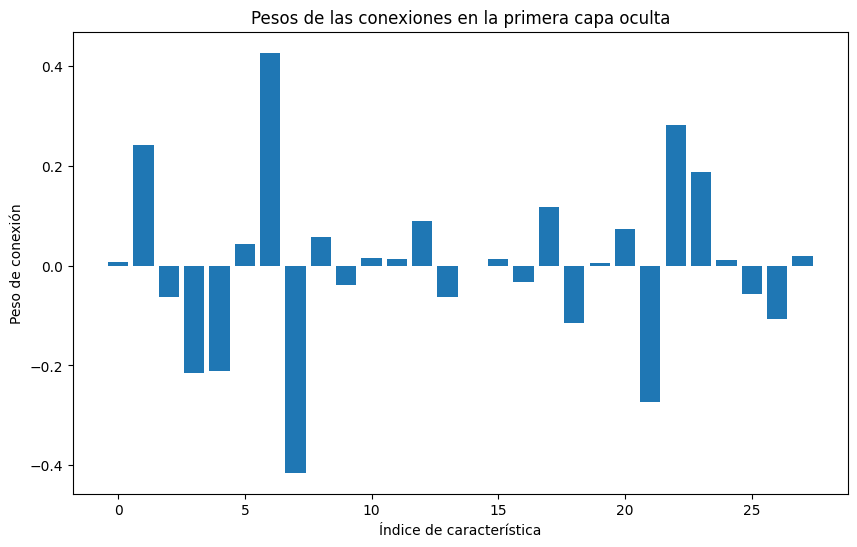

In [51]:
import numpy as np

# Obtener los pesos de las conexiones entre las neuronas
weights = red_neuronal.coefs_[0]
mean_weights = weights.mean(axis=1)
x = np.arange(len(mean_weights))


# Mostrar los pesos
for i, layer_weights in enumerate(weights):
    print(f'Capa {i}:')
    print(layer_weights)

plt.figure(figsize=(10, 6))
plt.bar(x, mean_weights)
plt.xlabel('Índice de característica')
plt.ylabel('Peso de conexión')
plt.title('Pesos de las conexiones en la primera capa oculta')
plt.show()

In [52]:
import pandas as pd

feature_names = modelo_logit[0:1].get_feature_names_out()

mdi_importances = pd.Series(
    modelo_logit[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [ ]:
plot_model(best_neuralnetwork, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Mostrar la imagen directamente en la notebook (puede requerir Graphviz)
Image('model_plot.png')

AttributeError: 'GridSearchCV' object has no attribute 'built'

Fin del código

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor


model = Sequential()
model.add(Dense(units=4, input_shape=(2,), activation='sigmoid'))
model.add(Dense(units=4,  activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Construye el Pipeline
MO = Pipeline([
    ('preprocessing', preprocessing),
    ('Classifier', model)
])

# Define los parámetros a ajustar
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid']
}

# Configura la búsqueda de hiperparámetros utilizando GridSearchCV
grid = GridSearchCV(estimator=MO, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

# Muestra los resultados
print(f"Mejores parámetros: {grid_result.best_params_}")
print(f"Precisión del modelo: {grid_result.best_score_}")



INFO:tensorflow:Assets written to: C:\Users\IP5-14~1\AppData\Local\Temp\tmpqzlrqavu\assets


INFO:tensorflow:Assets written to: C:\Users\IP5-14~1\AppData\Local\Temp\tmpqzlrqavu\assets


INFO:tensorflow:Assets written to: C:\Users\IP5-14~1\AppData\Local\Temp\tmpis05tm53\assets


INFO:tensorflow:Assets written to: C:\Users\IP5-14~1\AppData\Local\Temp\tmpis05tm53\assets


ValueError: Invalid parameter 'activation' for estimator Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('codificacion de categoricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'CAEC', 'CALC', 'MTRANS'])],
                                   verbose_feature_names_out=False)),
                ('Classifier',
                 <keras.src.engine.sequential.Sequential object at 0x000001813F9BB8B0>)]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
KerasClassifier.get_params().keys()

TypeError: BaseEstimator.get_params() missing 1 required positional argument: 'self'

In [ ]:
gnb2=joblib.load('bm_gnb.gz')
gnb2.fit(X_train, y_train)
#confusion_matrix(y_test, gnb.fit(X_test))
gnb2.best_params_

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\joblib\memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\compose\_column_transformer.py", line 914, in fit_transform
    result = self._call_func_on_transformers(
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\compose\_column_transformer.py", line 823, in _call_func_on_transformers
    return Parallel(n_jobs=self.n_jobs)(jobs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\utils\parallel.py", line 67, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\joblib\parallel.py", line 1863, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\joblib\parallel.py", line 1792, in _get_sequential_output
    res = func(*args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\utils\parallel.py", line 129, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\preprocessing\_encoders.py", line 1495, in fit
    fit_results = self._fit(
  File "c:\Users\CARLOS MARIO\Anaconda3\envs\tensor_310\lib\site-packages\sklearn\preprocessing\_encoders.py", line 85, in _fit
    raise ValueError(
ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).


In [ ]:
# modelo_logistico= LogisticRegression()
gnb=GaussianNB()
# arbol=DecisionTreeClassifier(criterion='gini', min_samples_split=100, min_samples_leaf=50)
random_forest = RandomForestClassifier(random_state=42)

def red():
    modelo1 = Sequential()
    modelo1.add(Dense(units=1, input_shape=(16,), activation='sigmoid'))
    modelo1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return modelo1
red1 = red()

modelos=[modelo_logistico,gnb,arbol,random_forest, red()]
resultados=[]
for modelo in modelos:
    nombre_modelo=f'{modelo}.joblib'
    flujo = Pipeline(
        [
            ("Preprocesamiento", preprocessing),
            ("Clasificador", modelo),
        ]
    )
    joblib.dump(flujo, nombre_modelo)
    salida=joblib.dump(flujo, nombre_modelo)
    resultados.append(salida)

from sklearn.metrics import classification_report
#print(classification_report(y_test, y_pred))

In [ ]:
resultados

In [ ]:

rf=joblib.load('r_RandomForestClassifier(random_state=42).joblib')
confusion_matrix(y_test, rf.predict(X_test))
rf



In [ ]:
rf.predict(X_test)

In [ ]:
log=joblib.load('r_LogisticRegression().joblib')
confusion_matrix(y_test, log.predict(X_test))

In [ ]:
nb=joblib.load('r_GaussianNB().joblib')
confusion_matrix(y_test, nb.predict(X_test))

In [ ]:
log.fit(X_train,y_train)